# AfriSpeech Transformer ASR

See app here: https://eb-asr-ayamra.streamlit.app/
Github Repo: https://github.com/eb-adutwum/deep-learning-asr-pr-3

# Imports & Setup

In [ ]:
import os
import sys
import random
import numpy as np
import torch
import pandas as pd
import tarfile
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
import torchcodec

IN_COLAB = 'google.colab' in sys.modules # doing this cuz I have been running on local and colab simultaneuosly

if IN_COLAB:
    print("Running in Google Colab")
    # install dependencies for colab
    !pip install transformers torchaudio soundfile jiwer sacrebleu torchcodec

    # gdrive
    from google.colab import drive
    drive.mount('/content/drive')


    if os.getcwd() not in sys.path:
        sys.path.append(os.getcwd())
else:
    print("Running locally")
    if os.getcwd() not in sys.path:
        sys.path.append(os.getcwd())

# local modules
try:
    from utils.config import Config
except ImportError:
    # If running in Colab or a different directory, try to find the 'code' folder
    print("Direct import failed. Searching for project root...")
    import sys

    # Common paths to check
    possible_paths = [
        "/content/drive/MyDrive/AfriSpeech/code",
        os.path.join(os.getcwd(), "code")
    ]

    found = False
    for path in possible_paths:
        if os.path.exists(os.path.join(path, "utils", "config.py")):
            print(f"Found project root at: {path}")
            if path not in sys.path:
                sys.path.append(path)
            found = True
            break

    if not found:
        # search for utils/config.py
        print("Searching recursively...")
        for root, dirs, files in os.walk("/content"):
            if "utils" in dirs and "config.py" in os.listdir(os.path.join(root, "utils")):
                print(f"Found project root at: {root}")
                if root not in sys.path:
                    sys.path.append(root)
                found = True
                break

    if not found:
        raise ImportError("Could not find project root containing 'utils/config.py'. Please ensure the code is uploaded and sys.path is correct.")

# try importing again (will fail if still not found)
from utils.config import Config
from data.dataset import AfriSpeechDataset, collate_fn
from data.preprocessing import AudioPreprocessor, TextPreprocessor
from models.pretrained_asr import PretrainedASRModel
from training.trainer import Trainer
from training.evaluator import Evaluator
from utils.visualization import plot_training_history, save_metric_curves

# random seed for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# Data Processing

In [24]:
if IN_COLAB:
    BASE_PATH = "/content/drive/MyDrive/AfriSpeech" # 'data' for local
    ACCENTS = ["twi"]
    SPLITS = ["train", "dev", "test"]

    # def extract_archives(base_path, accents, splits):
    #     for accent in accents:
    #         accent_audio_dir = os.path.join(base_path, "audio", accent)

    #         for split in splits:
    #             tar_name = f"{split}_{accent}_0.tar.gz"
    #             tar_path = os.path.join(accent_audio_dir, tar_name)

    #             if os.path.exists(tar_path):
    #                 print(f"extracting {tar_path}...")
    #                 # We'll extract to /content/data/{accent}
    #                 extract_dir = os.path.join("/content/data", accent, split)
    #                 os.makedirs(extract_dir, exist_ok=True)

    #                 # Check if already extracted to avoid re-doing it
    #                 if not os.path.exists(os.path.join(extract_dir, "data")):
    #                     with tarfile.open(tar_path, "r:gz") as tar:
    #                         tar.extractall(path=extract_dir)
    #                     print(f"extracted to {extract_dir}")
    #                 else:
    #                     print(f"Already extracted to {extract_dir}")
    #             else:
    #                 print(f"No zip for {accent} {split}, skipped...")

    # Run extraction
    # extract_archives(BASE_PATH, ACCENTS, SPLITS)

    dfs = {split: [] for split in SPLITS}

    def create_dfs(base_path, accents, splits):
        for accent in accents:
            accent_transcript_dir = os.path.join(base_path, "transcript", accent)

            for split in splits:
                csv_path = os.path.join(accent_transcript_dir, f"{split}.csv")

                # audio_dir = os.path.join("/content/data", accent, split, "data", "data", "intron")

                audio_dir = os.path.join(base_path, "audio", accent, f"{split}_{accent}_0", "data", "data", "intron")

                if not os.path.exists(csv_path):
                    print(f"Didn't find the csv {csv_path}, skipped...")
                    continue

                df = pd.read_csv(csv_path)

                def make_relative_path(row):
                    # Normalize path separators
                    audio_path = row["audio_paths"].replace("\\", "/")
                    parts = audio_path.split("/")[-2:]
                    # Construct absolute path
                    return os.path.join(audio_dir, parts[0], parts[1]).replace("\\", "/")

                # We rename this to 'audio_paths' so the Dataset class uses it directly
                df["audio_paths"] = df.apply(make_relative_path, axis=1)
                dfs[split].append(df)

    create_dfs(BASE_PATH, ACCENTS, SPLITS)

    if dfs["train"]:
        df_train = pd.concat(dfs["train"], ignore_index=True)
        df_val = pd.concat(dfs["dev"], ignore_index=True)
        df_test = pd.concat(dfs["test"], ignore_index=True)

        # save csvs
        df_train.to_csv("/content/train_processed.csv", index=False)
        df_val.to_csv("/content/val_processed.csv", index=False)
        df_test.to_csv("/content/test_processed.csv", index=False)

        print(f"Processed dataframes saved to /content/")
        print(f"Train size: {len(df_train)}")
    else:
        print("No data found. Check BASE_PATH.")

Processed dataframes saved to /content/
Train size: 1315


# Config

In [25]:
config = Config()

# override config
if IN_COLAB and os.path.exists("/content/train_processed.csv"):
    config.data.train_csv = "/content/train_processed.csv"
    config.data.dev_csv = "/content/val_processed.csv"
    config.data.test_csv = "/content/test_processed.csv"
    # we set base_dir to root
    config.data.audio_base_dir = "/"

# config exp values
config.training.batch_size = 4
config.training.num_epochs = 2
config.training.learning_rate = 5e-5
config.model.model_name = 'openai/whisper-tiny' # Use tiny for faster testing in notebook

print("Configuration:")
print(f"Model: {config.model.model_name}")
print(f"Batch Size: {config.training.batch_size}")
print(f"Epochs: {config.training.num_epochs}")
print(f"Learning Rate: {config.training.learning_rate}")
print(f"Device: {config.device}")
print(f"Train CSV: {config.data.train_csv}")
print(f"Audio Base: {config.data.audio_base_dir}")

Configuration:
  Model: openai/whisper-tiny
  Batch Size: 4
  Epochs: 2
  Learning Rate: 5e-05
  Device: cpu
  Train CSV: /content/train_processed.csv
  Audio Base: /


In [27]:
import pandas as pd

# problematic audio path
problematic_audio_path = '/content/drive/MyDrive/AfriSpeech/audio/twi/train_twi_0/data/data/intron/a016fe11-c0d2-419e-9d8b-3d59026b7e56/e70055e68d89f0b339d4be417499df93.wav'

df_train = pd.read_csv('/content/train_processed.csv')

original_len = len(df_train)
df_train = df_train[df_train['audio_paths'] != problematic_audio_path]

# save
df_train.to_csv('/content/train_processed.csv', index=False)

print(f"Removed {original_len - len(df_train)} row(s) from train_processed.csv")
print(f"New train_processed.csv size: {len(df_train)}")

Removed 0 row(s) from train_processed.csv
New train_processed.csv size: 1314


# Data Preparation

In [28]:
# audio preprocessor
audio_preprocessor = AudioPreprocessor(
    sample_rate=config.data.sample_rate,
    n_fft=config.data.n_fft,
    hop_length=config.data.hop_length,
    n_mels=config.data.n_mels,
    f_min=config.data.f_min,
    f_max=config.data.f_max
)

text_preprocessor = None

# init models
print(f"Initializing model wrapper to get processor...")
temp_model = PretrainedASRModel(
    model_name=config.model.model_name,
    freeze_feature_extractor=config.model.freeze_feature_extractor,
    freeze_encoder=config.model.freeze_encoder,
    vocab_size=config.model.vocab_size
)
processor = getattr(temp_model, 'processor', None)
model_type = temp_model.model_type
del temp_model # free ram

# tokenization
pad_token_id = 0
if processor and hasattr(processor, 'tokenizer'):
    if processor.tokenizer.pad_token is None:
        processor.tokenizer.pad_token = processor.tokenizer.eos_token
    pad_token_id = processor.tokenizer.pad_token_id
else:
    print("Building custom vocabulary...")
    # build vocab
    def build_vocab_list(csv_path: str) -> list:
        import pandas as pd
        df = pd.read_csv(csv_path)
        return df['transcript'].astype(str).tolist()

    train_texts = build_vocab_list(config.data.train_csv)
    text_preprocessor = TextPreprocessor(tokenizer_type=config.data.tokenizer_type)
    text_preprocessor.build_vocab(train_texts)
    pad_token_id = text_preprocessor.vocab.get('<pad>', 0)
    print(f"Vocabulary size: {text_preprocessor.vocab_size}")

# create datasets
print("Loading datasets...")
dataset_kwargs = {
    'audio_preprocessor': audio_preprocessor,
    'text_preprocessor': text_preprocessor,
    'processor': processor,
    'model_type': model_type,
    'max_audio_length': config.data.max_audio_length,
    'min_audio_length': config.data.min_audio_length
}

train_dataset = AfriSpeechDataset(
    csv_path=config.data.train_csv,
    audio_base_dir=config.data.audio_base_dir,
    use_augmentation=config.data.use_augmentation,
    split='train',
    **dataset_kwargs
)

val_dataset = AfriSpeechDataset(
    csv_path=config.data.dev_csv,
    audio_base_dir=config.data.audio_base_dir,
    use_augmentation=False,
    split='dev',
    **dataset_kwargs
)

test_dataset = AfriSpeechDataset(
    csv_path=config.data.test_csv,
    audio_base_dir=config.data.audio_base_dir,
    use_augmentation=False,
    split='test',
    **dataset_kwargs
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# create dataloaders
from functools import partial
collate = partial(collate_fn, pad_token_id=pad_token_id if pad_token_id is not None else 0, label_pad_token_id=-100)

num_workers = 0 # Set to 0 for Windows/Notebook compatibility usually
pin_memory = config.device == 'cuda'

train_loader = DataLoader(
    train_dataset,
    batch_size=config.training.batch_size,
    shuffle=True,
    collate_fn=collate,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    collate_fn=collate,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    collate_fn=collate,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Initializing model wrapper to get processor...
Loading datasets...
Train samples: 1314
Val samples: 186
Test samples: 58


# Model Initialization

In [29]:
print(f"Initializing model: {config.model.model_name}...")
model = PretrainedASRModel(
    model_name=config.model.model_name,
    freeze_feature_extractor=config.model.freeze_feature_extractor,
    freeze_encoder=config.model.freeze_encoder,
    vocab_size=config.model.vocab_size
)

print(f"Model initialized. Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Initializing model: openai/whisper-tiny...
Model initialized. Parameters: 37,760,640
Trainable parameters: 29,552,256


# Training Setup

In [30]:
# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.training.learning_rate,
    weight_decay=config.training.weight_decay,
    betas=(0.9, 0.98)
)

# Scheduler
total_steps = len(train_loader) * config.training.num_epochs
warmup_steps = config.training.warmup_steps
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_eval_loader=None,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config.device,
    output_dir=config.training.output_dir,
    save_steps=config.training.save_steps,
    eval_steps=config.training.eval_steps,
    logging_steps=config.training.logging_steps,
    max_grad_norm=config.training.max_grad_norm,
    fp16=config.training.fp16,
    gradient_accumulation_steps=config.training.gradient_accumulation_steps,
    label_smoothing=config.training.label_smoothing
)

# Training loop

In [ ]:
print("\nStarting training...")
for epoch in range(config.training.num_epochs):
    print(f"\nEpoch {epoch + 1}/{config.training.num_epochs}")
    train_loss = trainer.train_epoch()
    print(f"Train loss: {train_loss:.4f}")

    # Evaluate on validation set
    val_metrics = trainer.evaluate()
    print(f"Val loss: {val_metrics['loss']:.4f}")
    print(f"Val CER: {val_metrics['cer']:.4f}")
    print(f"Val WER: {val_metrics['wer']:.4f}")
    print(f"Val BLEU: {val_metrics['bleu']:.4f}")

    # Store metrics for visualization
    trainer.train_losses.append(train_loss)
    trainer.val_losses.append(val_metrics['loss'])
    trainer.val_cers.append(val_metrics['cer'])
    trainer.val_wers.append(val_metrics['wer'])
    trainer.val_bleus.append(val_metrics['bleu'])

# Evaluation & visualization

Checkpoint saved to checkpoints/pretrained_transformer1/final_model.pt

Final model saved.

Generating visualizations...
Training history saved to /content/visualizations_notebook/training_history.png


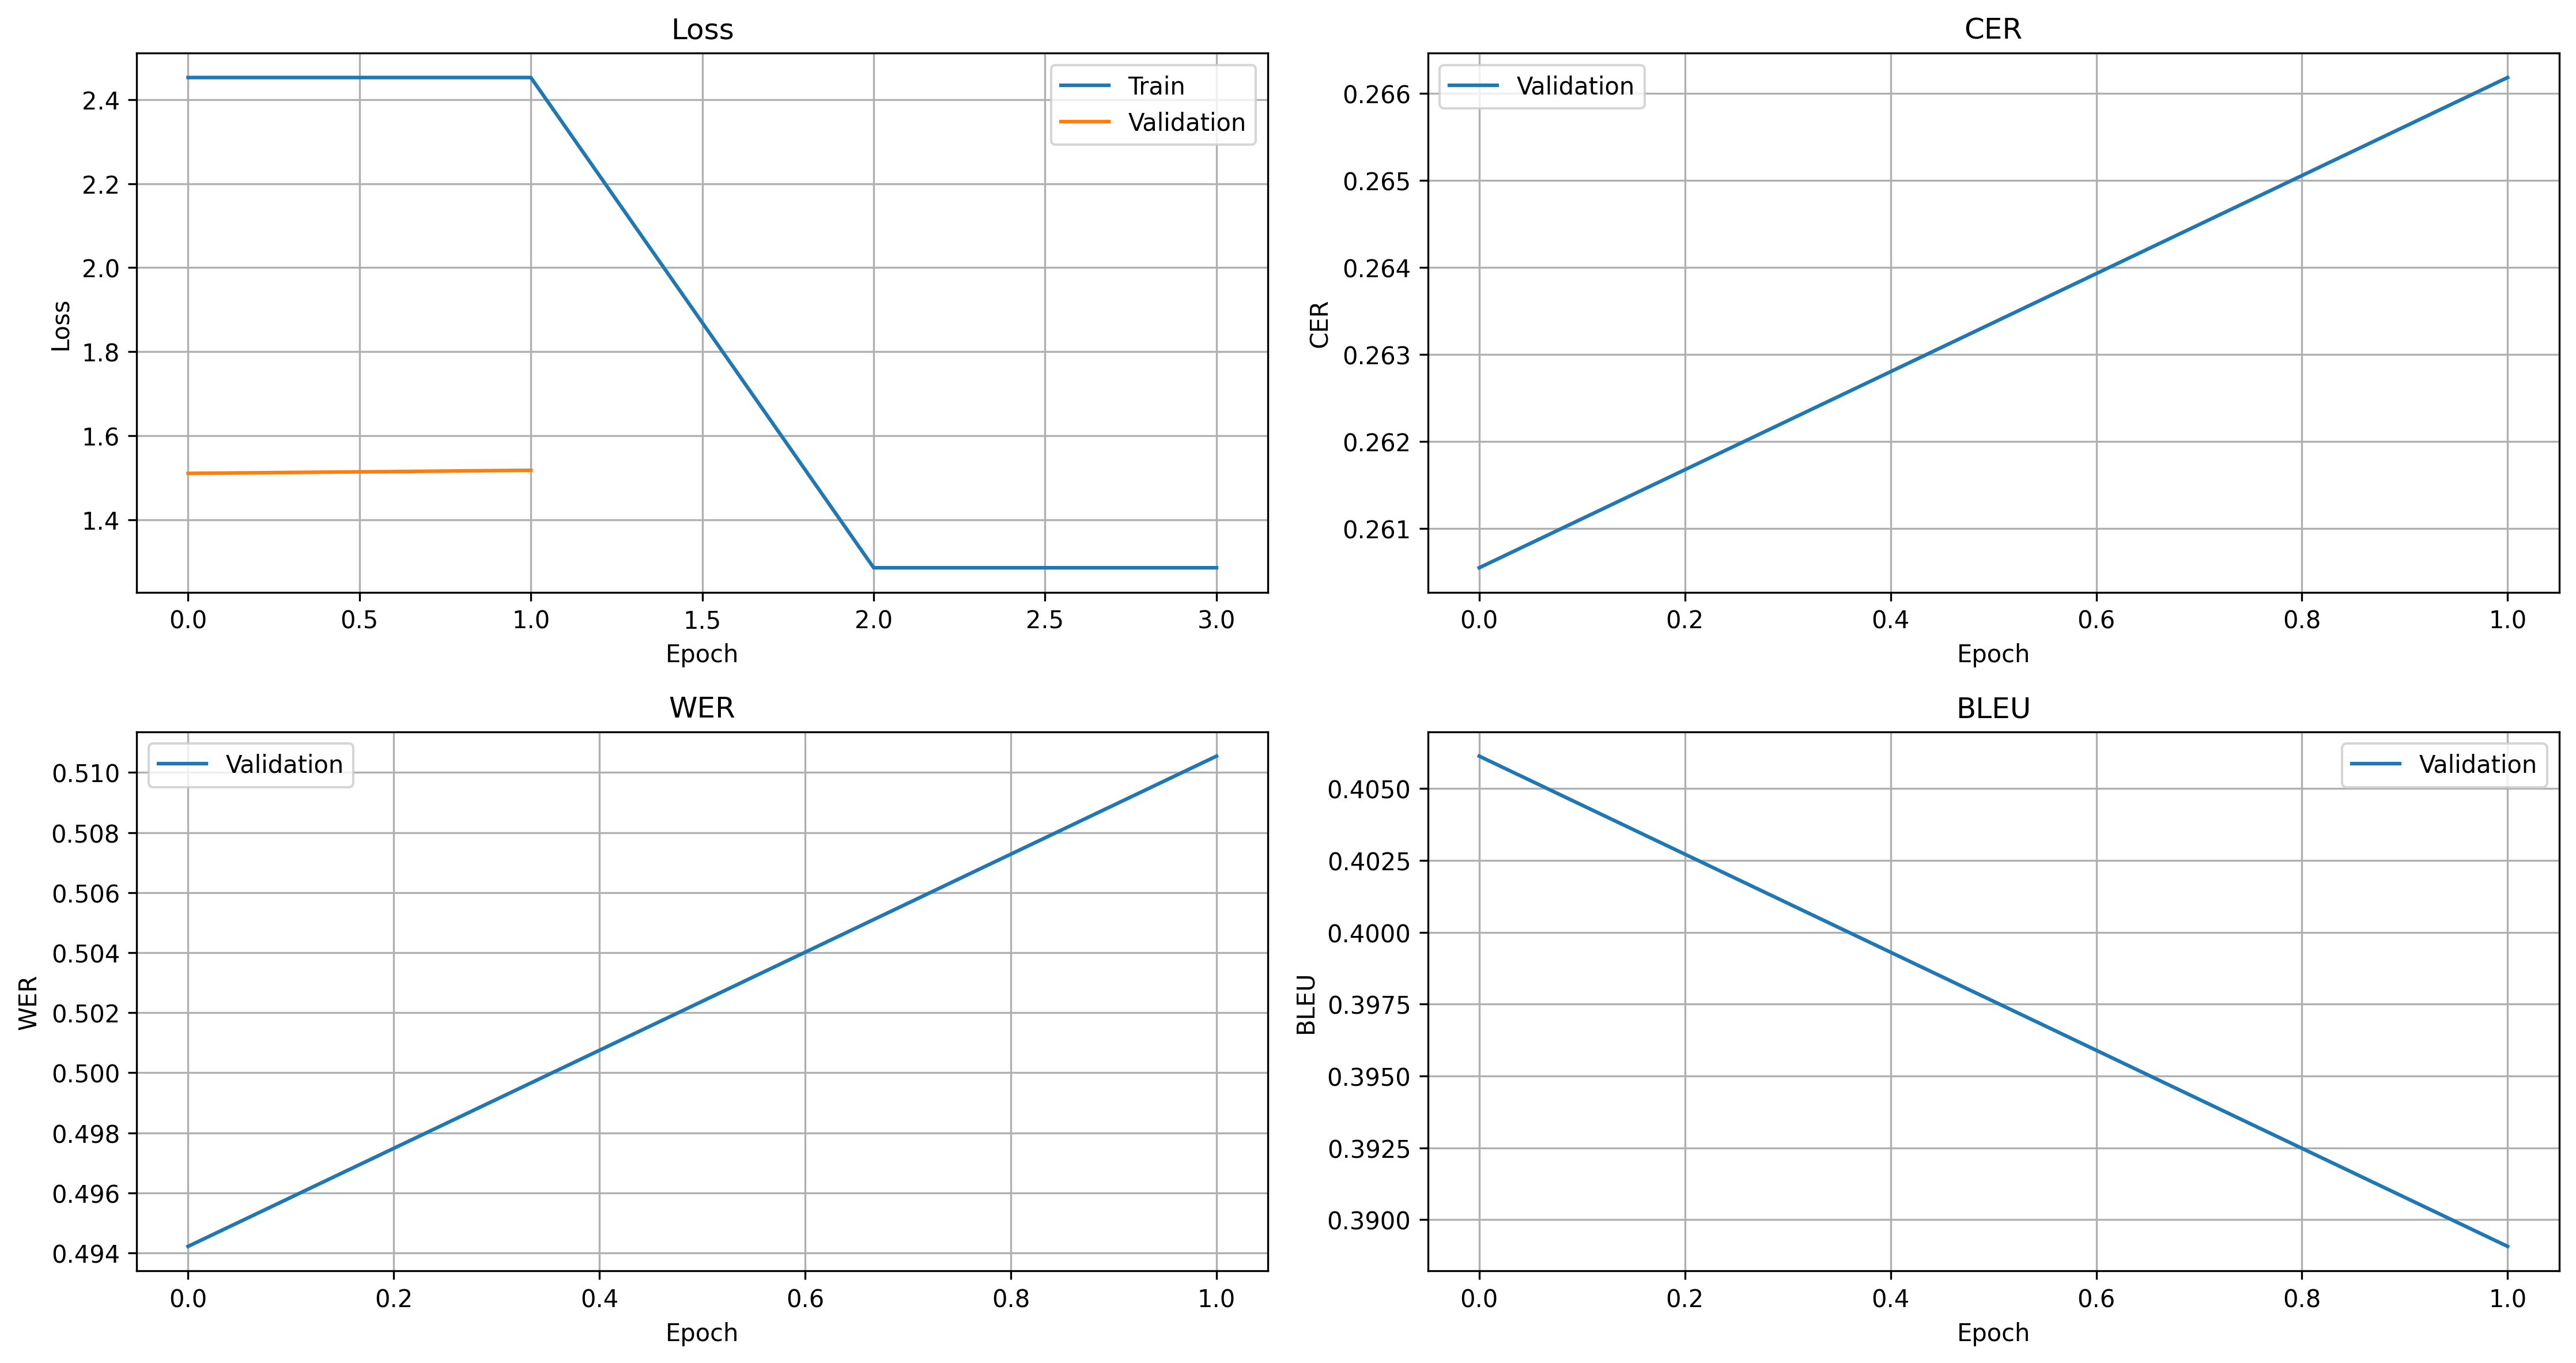

In [32]:
# 7. Evaluation & Visualization

# Save final checkpoint
trainer.save_checkpoint('asr_model.pt')
print("\nFinal model saved.")

# Generate visualizations
print("\nGenerating visualizations...")
viz_dir = os.path.join(os.getcwd(), 'visualizations_notebook')
os.makedirs(viz_dir, exist_ok=True)

history_path = os.path.join(viz_dir, 'training_history.png')
plot_training_history(
    train_losses=trainer.train_losses,
    val_losses=trainer.val_losses,
    train_eval_losses=None,
    train_cers=None,
    val_cers=trainer.val_cers,
    train_wers=None,
    val_wers=trainer.val_wers,
    train_bleus=None,
    val_bleus=trainer.val_bleus,
    save_path=history_path
)

# Display the plot in the notebook
from IPython.display import Image, display
display(Image(filename=history_path))

# Test set evaluation

In [34]:
print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

evaluator = Evaluator(trainer.model, device=config.device)
test_metrics = evaluator.evaluate(test_loader, decode_fn=None)

print(f"\nTest Results:")
print(f"Test CER: {test_metrics['cer']:.4f}")
print(f"Test WER: {test_metrics['wer']:.4f}")
print(f"Test BLEU: {test_metrics['bleu']:.4f}")

# Show sample predictions vs ground truth
print("\n" + "="*80)
print("SAMPLE PREDICTIONS vs GROUND TRUTH (First 10 examples)")
print("="*80)
predictions = test_metrics.get('predictions', [])
references = test_metrics.get('references', [])

for i, (pred, ref) in enumerate(zip(predictions[10:11], references[10:11])):
    print(f"\nExample {i+1}:")
    print(f"GROUND TRUTH: {ref}")
    print(f"PREDICTION:   {pred}")
    print("-" * 80)


EVALUATING ON TEST SET


Evaluating: 100%|██████████| 15/15 [05:19<00:00, 21.33s/it]


Test Results:
Test CER: 0.1907
Test WER: 0.3928
Test BLEU: 0.4843

SAMPLE PREDICTIONS vs GROUND TRUTH (First 10 examples)

Example 1:
GROUND TRUTH: Strength and tautness of ligaments and joint capsules.
PREDICTION:   Straight and thoughtness of ligaments and joint capsules.
--------------------------------------------------------------------------------


In [35]:
for i, (pred, ref) in enumerate(zip(predictions[10:21], references[10:21])):
    print(f"\nExample {i+1}:")
    print(f"GROUND TRUTH: {ref}")
    print(f"PREDICTION:   {pred}")
    print("-" * 80)


Example 1:
GROUND TRUTH: Strength and tautness of ligaments and joint capsules.
PREDICTION:   Straight and thoughtness of ligaments and joint capsules.
--------------------------------------------------------------------------------

Example 2:
GROUND TRUTH: So can we also say your team members in one way or the other contributed to your success?
PREDICTION:   So can we also say your team members in one way or that are contributing to your success?
--------------------------------------------------------------------------------

Example 3:
GROUND TRUTH: Either no one is being challenged or sometimes everyone is being challenged, even people like Frank Bicking, and that is the saddest part.
PREDICTION:   I don't know when it's been challenged or sometimes everyone is being challenged, even people like Frank Bikin, and that is the satisfiedest part.
--------------------------------------------------------------------------------

Example 4:
GROUND TRUTH: This is accompanied by maintenan